In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import json
from scipy.spatial import Delaunay
import skimage as ski
import einops

def read_img(img_name, img_dir = 'in_dir/', grayscale=False, r=None):
    if '.' not in img_name:
        img_name += '.jpg'
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    if r:
        img = np.rot90(img, k=r)
    return img
images_out = 'images_out/' 
def save_img(fname, img_out, out_dir = 'images_out/part_a/', grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

In [2]:
# Computes the homography p’=Hp, where H
# is a 3x3 matrix with 8 degrees of freedom
def compute_h(img_1_pts, img_2_pts):
    assert len(img_1_pts) == len(img_2_pts)
    n = len(img_1_pts)
    img_1_pts = np.asarray(img_1_pts)
    img_1_hom = to_homogenous(img_1_pts)
    img_2_pts = np.asarray(img_2_pts)
    img_2_pts_flat = np.ndarray.flatten(img_2_pts)
    
    len_H = 8
    A = np.zeros((2*n, len_H))

    A[0:-1:2, :3] = img_1_hom.T # Set first 3 columns with p
    A[1::2, 3:6] = img_1_hom.T  # Set columns 3-5 with p

    # Set end columns with p
    A[::2, -2:] = img_1_pts 
    A[1::2, -2:] = img_1_pts 

    # Multiply end columns with p'
    A[:, -2] *= -img_2_pts_flat
    A[:, -1] *= -img_2_pts_flat
    b = img_2_pts_flat
    x, res, rank, _ = np.linalg.lstsq(A, b, rcond=None)
    H = np.ones(9)
    H[:8] = x
    H = np.reshape(H, (3,3))
    return H, res, rank
# Adds ones on axis 1
def to_homogenous(inp):
    inp = np.asarray(inp)
    ones = np.ones((inp.shape[0],1))
    return np.concatenate((inp, ones), axis=1).T

# Takes homogenous points and returns normal
def homogenous_to_non(inp):
    inp = np.asarray(inp)
    z = inp[-1, :]
    inp = inp[:-1, :] / z
    return inp.T

# Applies homography to non-homogenous coordinate inp, returning the new coords
# also in non-homogenous form
def apply_h(h, inp):
    homo = to_homogenous(inp)
    transformed = h @ homo
    return homogenous_to_non(transformed)

def get_corners(img):
    img_corners = [[img.shape[1], img.shape[0]], [img.shape[1], 0], [0,0], [0, img.shape[0]]]
    return img_corners

def get_inv(A):
    return np.linalg.inv(A)

# Takes in non-homogenous points
def create_polygon(points):
    points = np.asarray(points)
    cc, rr = ski.draw.polygon(points[:,0], points[:,1], shape=None)
    return cc,rr

In [3]:
### Tests to confirm homography calculated correctly
img_1_pts = [[6,1], [2,4], [3,7], [5,4]]
img_1_pts = np.asarray(img_1_pts)
img_1_hom = to_homogenous(img_1_pts)
ans = compute_h(img_1_pts, img_1_pts)
H = ans[0]
after_H = H @ img_1_hom
assert np.all(np.isclose(img_1_hom, after_H))

H = [[10,4,6],
     [2.3,4.3,-4],
     [0, 0, 1]]
img_2_hom = H @ img_1_hom
img_2_normal = homogenous_to_non(img_2_hom)
ans = compute_h(img_1_pts, img_2_normal)
H_computed = ans[0]
assert np.all(np.isclose(H, H_computed))

In [4]:
def load_corr_pts(fname, in_dir='images_in/', single=True):
    if 'json' not in fname: fname += '.json'
    corr_file = in_dir + fname
    f = open(corr_file)
    correspondences = json.load(f)
    img_1_points = np.array(correspondences['im1Points'])
    img_2_points = np.array(correspondences['im2Points'])
    if single:
        return img_1_points
    else:
        return img_1_points, img_2_points

def plot_pts(pts, color='blue'):
    x, y = pts[:, 0], pts[:, 1]
    [plt.text(x[i], y[i], f'{i}', fontsize=10, ha='right', color=color) for i in range(len(x))]
    plt.scatter(x,y, color=color, s=5)

In [5]:
# Sets up img for interpolation
def create_interp_grid(img):
    X, Y = np.mgrid[:img.shape[0], :img.shape[1]]
    points = np.dstack((X.ravel(), Y.ravel())).squeeze()
    # Flatten img to use for interpolation
    flat_img = einops.rearrange(img, ('h w c -> (h w) c'))
    color_interp = scipy.interpolate.NearestNDInterpolator(points, flat_img)
    return color_interp

# Applies homography to img
def warp(H, img, new_shape = None, color_interp=None, out_dir='images_out/part_a/part_2/', fname=None):
    if new_shape == None: new_shape = img.shape
    new_image = np.zeros(new_shape)
    cc, rr = create_polygon(get_corners(new_image))
    src_coords = np.array([cc, rr, np.ones_like(rr)])

    new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
    c_n, r_n = new[:, 0], new[:, 1]
    rr = np.clip(rr, 0, new_image.shape[0]-1)
    cc = np.clip(cc, 0, new_image.shape[1]-1)

    # Interpolate at to get the colors of the points when inv mapped
    mask_c = c_n < img.shape[1]
    mask_c *= c_n >= 0
    mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

    mask_r = r_n < img.shape[0]
    mask_r *= r_n >= 0
    mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
    # mask = mask_r * mask_c

    if color_interp == None:
        color_interp = create_interp_grid(img)
    tri_interp = color_interp((r_n, c_n))
    tri_interp_mask_c = np.where(mask_c, tri_interp, np.ones(3))
    tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.ones(3))

    # new_image[rr, cc] = tri_interp
    new_image[rr, cc] = tri_interp_mask_rc
    plt.imshow(new_image)
    if fname != None:
        save_img(fname, new_image, out_dir=out_dir)
    return new_image

In [6]:
def shift_pts(pts, w_extend=0, h_extend=0, offset_x=0, offset_y=0):
    new_pts = pts.copy()
    for i in range(len(pts)):
        new_pts[i] = pts[i][0] + (-1)**(i<2)* w_extend + offset_x, pts[i][1] + (-1)**(i==0 or i==3)* h_extend + offset_y
    return new_pts
        
def get_pts_from_corner(pts, tl, br, w_extend=0, h_extend=0, offset_x=0, offset_y=0):
    top_left, bottom_right = pts[tl], pts[br]
    h, w = -top_left[1] + bottom_right[1], bottom_right[0] - top_left[0]
    top_right = bottom_right[0], bottom_right[1] - h
    bottom_left = bottom_right[0] - w, bottom_right[1]
    pts = np.asarray([top_left, bottom_left, bottom_right, top_right])
    return shift_pts(pts, w_extend=w_extend, h_extend=h_extend, offset_x=offset_x, offset_y=offset_y)

In [7]:
img_dir = 'images_in/'

macbook_pts = load_corr_pts('macbook', single=True)
img = read_img('macbook', img_dir)

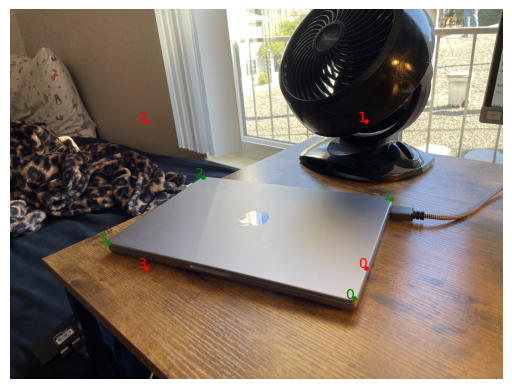

In [8]:
w, h = 900, 600
x, y = 2016, 1512
target_mac_pts = np.asarray([[x+w,y+h], [x+w,y-h], [x-w,y-h], [x-w,y+h]])
# target_mac_pts = np.asarray([[x-w,y-h], [x-w,y+h], [x+w,y+h], [x+w,y-h] ])
# img_2_points = get_corners(img)

plot_pts(macbook_pts, color='green')
plot_pts(target_mac_pts, color='red')
H, _, _ = compute_h(macbook_pts, target_mac_pts)
plt.imshow(img)
plt.axis('off')
plt.savefig('images_out/part_a/part_2/' + 'macbook_corr', bbox_inches='tight')

In [36]:
macbook_interp = create_interp_grid(img)

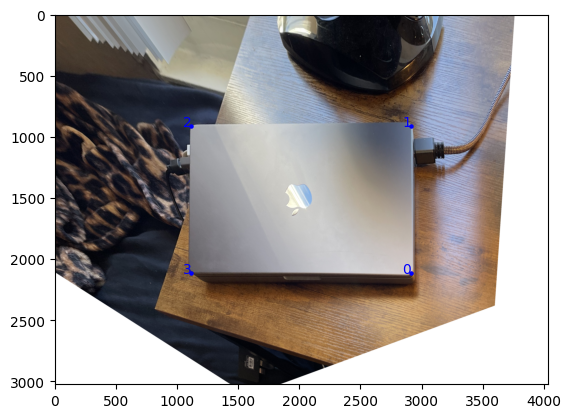

In [37]:
H, _, _ = compute_h(macbook_pts, target_mac_pts)
plot_pts(target_mac_pts)
mac_rectified = warp(H, img, color_interp=macbook_interp, fname='macbook')

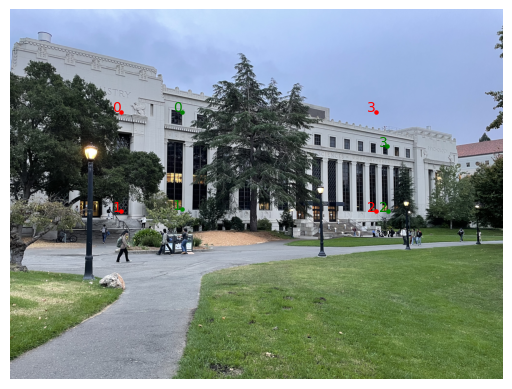

In [41]:
vlsb_pts = load_corr_pts('vlsb', single=True)
vlsb = read_img('vlsb_horizontal', img_dir)
target_vlsb_pts = get_pts_from_corner(vlsb_pts, 0, -1, w_extend=200, offset_x=-300)
plt.imshow(vlsb)
vlsb_pts_4 = np.asarray([vlsb_pts[0,:], vlsb_pts[3,:], vlsb_pts[-1,:], vlsb_pts[4,:]])
plot_pts(vlsb_pts_4, color='green')
plot_pts(target_vlsb_pts, color='red')
plt.axis('off')
plt.savefig('images_out/part_a/part_2/' + 'vlsb_corr', bbox_inches='tight')

In [33]:
vlsb_interp = create_interp_grid(vlsb)
H, _, _ = compute_h(vlsb_pts_4, target_vlsb_pts)

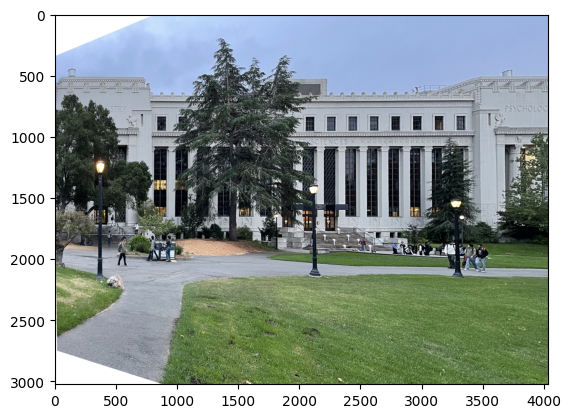

In [34]:
vlsb_warped = warp(H, vlsb, color_interp=vlsb_interp, fname='vlsb_final')

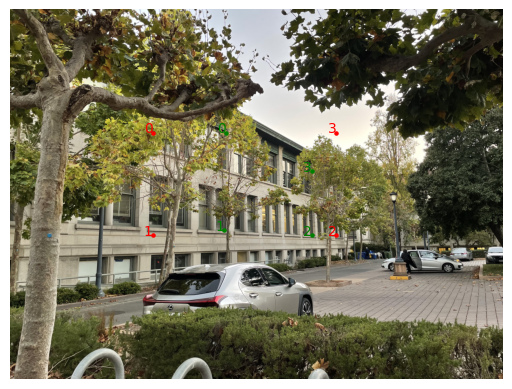

In [40]:
building_pts = load_corr_pts('building', single=True)
building = read_img('building', img_dir)
target_bldg_pts = get_pts_from_corner(building_pts, 0, 2, w_extend=400, offset_x=-200)
plt.imshow(building)
# img_pts_4 = np.asarray([vlsb_pts[0,:], vlsb_pts[3,:], vlsb_pts[-1,:], vlsb_pts[4,:]])
plot_pts(building_pts, color='green')
plot_pts(target_bldg_pts, color='red')
plt.axis('off')
plt.savefig('images_out/part_a/part_2/' + 'bldg_corr', bbox_inches='tight')

In [18]:
bldg_interp = create_interp_grid(building)
H, _, _ = compute_h(building_pts, target_bldg_pts)

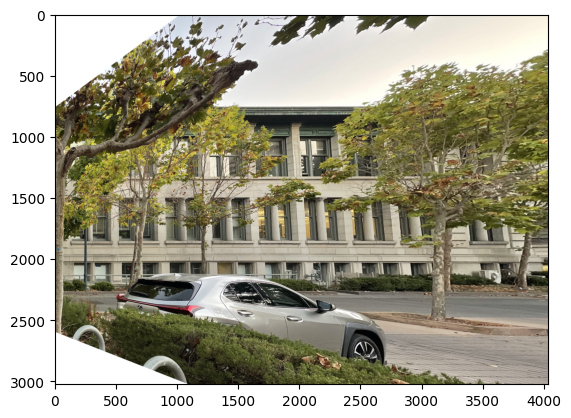

In [19]:
bldg_warped = warp(H, building, color_interp=bldg_interp, fname='bldg')

### Part 3: Mosaics

In [8]:
# Applies homography to img
def warp_new(H, img, corners, new_shape = None, offset=[0,0], color_interp=None, out_dir='images_out/part_a/part_2/', fname=None):
    if new_shape == None: new_shape = img.shape
    new_image = np.zeros(new_shape)
    cc, rr = create_polygon(corners)
    cc -= offset[0]
    rr -= offset[1]
    src_coords = np.array([cc, rr, np.ones_like(rr)])
    
    new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
    c_n, r_n = new[:, 0], new[:, 1]

    # Interpolate at to get the colors of the points when inv mapped
    mask_c = c_n < img.shape[1]
    mask_c *= c_n >= 0
    mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

    mask_r = r_n < img.shape[0]
    mask_r *= r_n >= 0
    mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
    # mask = mask_r * mask_c

    if color_interp == None:
        color_interp = create_interp_grid(img)
    tri_interp = color_interp((r_n, c_n))
    tri_interp_mask_c = np.where(mask_c, tri_interp, np.zeros(3))
    tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.zeros(3))

    # new_image[rr, cc] = tri_interp
    cc += offset[0]
    rr += offset[1]
    rr = np.clip(rr, 0, new_image.shape[0]-1)
    cc = np.clip(cc, 0, new_image.shape[1]-1)

    new_image[rr, cc] = tri_interp_mask_rc
    plt.imshow(new_image)
    if fname != None:
        save_img(fname, new_image, out_dir=out_dir)
    return new_image

def translate_img(img, new_shape, offset_x=0, offset_y=0):
    new_img = np.zeros(new_shape)
    upper_y = min(offset_y+img.shape[0], new_img.shape[0])
    upper_x = min(offset_x+img.shape[1], new_img.shape[1])
    new_img[offset_y:upper_y, offset_x:upper_x] = img[:upper_y-offset_y, :upper_x-offset_x]
    return new_img

def make_mask_3_channel(mask):
    new_mask = np.zeros((mask.shape[0],mask.shape[1],3))
    new_mask[:,:,0] = mask
    new_mask[:,:,1] = mask
    new_mask[:,:,2] = mask
    return new_mask

def or_masks(masks):
    masks = np.sum(masks, axis=0)
    return np.clip(masks, 0, 1)

def and_masks(masks):
    masks = np.sum(masks, axis=0)
    masks = (masks > 1).astype(int).astype(float)
    return np.clip(masks, 0, 1)

def xor_masks(masks):
    return 1-or_masks(masks)

# Computes mask from the polygon defined by the img corners.
# Mask is 1 inside the image corners, 0 outside
def make_mask_from_corners(img, corners):
    mask_poly = create_polygon(corners)
    cc, rr = mask_poly
    mask = np.zeros(img.shape[:2])

    rr = np.clip(rr, 0, mask.shape[0]-1)
    cc = np.clip(cc, 0, mask.shape[1]-1)
    mask[rr,cc] = 1
    mask = make_mask_3_channel(mask)
    return mask

def compute_offset_from_corners(corners):
    max_x = int(np.max(corners[:,0]))
    min_x = int(np.min(corners[:,0]))
    max_y = int(np.max(corners[:,1]))
    min_y = int(np.min(corners[:,1]))
    
    offset_y = abs(min(0, (min_y)))
    offset_x = abs(min(0, (min_x)))
    return np.asarray([offset_x, offset_y])

In [9]:
def alpha_blend_mosaic(images, masks):
    return images[0] * (1-or_masks(masks[1:])) + masks[1]*images[1] + (1-masks[1]) * images[2]

def compute_mosaic(name, l=3, c=2, r=1, size_x=5500, size_y=5500, offset_extra_x=0, offset_extra_y=0):
    l,c,r = str(l), str(c), str(r)
    pts_2_to_1, pts_2_to_3 = name + '_'+c+'_to_'+r, name + '_'+c+'_to_'+l
    center_pts, right_pts = load_corr_pts(pts_2_to_1, single=False)

    # Load images
    img_left = read_img(name + '_'+l, img_dir, r=3)
    img_center = read_img(name + '_'+c, img_dir, r=3)
    img_right = read_img(name + '_'+r, img_dir, r=3)

    print(img_center.shape)
    
    # Warp right to center
    right_interp = create_interp_grid(img_right) # Interpolate grid
    H_1_to_2, _, _ = compute_h(right_pts, center_pts) # Compute H
    
    new_right_corners = apply_h(H_1_to_2, get_corners(img_right))
    # print(new_right_corners)
    offset_to_not_get_neg_1_to_2 = compute_offset_from_corners(new_right_corners)
    
    new_size_x, new_size_y = size_x, size_y
    img_1_to_2_warp = warp_new(H_1_to_2, img_right,
                                corners = new_right_corners + offset_to_not_get_neg_1_to_2,
                                new_shape=(new_size_y, new_size_x, 3),
                                # new_shape=(max(max_y, vlsb_right.shape[0]) - min(0, min_y), max(max_x, vlsb_right.shape[1]) - min(0, min_x), 3),
                                # new_shape=(max_y-min_y, max_x, 3),
                                offset=offset_to_not_get_neg_1_to_2, color_interp=right_interp)
    
    # Apply extra shift to align all center img in canvas
    extra_trans_after_1_to_2_warp = [1500+ offset_extra_x, 150+ offset_extra_y]
    total_shift = offset_to_not_get_neg_1_to_2 + extra_trans_after_1_to_2_warp
    
    img_1_to_2_warp_shift = translate_img(img_1_to_2_warp, img_1_to_2_warp.shape, 
                                          offset_y=extra_trans_after_1_to_2_warp[1], 
                                          offset_x=extra_trans_after_1_to_2_warp[0])
    trans_center_img = translate_img(img_center, img_1_to_2_warp_shift.shape, offset_x=total_shift[0], offset_y=total_shift[1])
    # plt.imshow(img_1_to_2_warp_shift)
    
    
    # Compute mask for right img
    right_corners_shifted = new_right_corners + total_shift
    center_corners = get_corners(img_center)
    center_corners_shifted = center_corners + total_shift
    
    mask_right = make_mask_from_corners(img_1_to_2_warp_shift, right_corners_shifted)
    mask_center = make_mask_from_corners(trans_center_img, center_corners_shifted)
    
    comb_init = img_1_to_2_warp_shift + trans_center_img*mask_right    
    
    #################################################################################################
    ### Warp left to (center+right)
    center_pts, left_pts = load_corr_pts(pts_2_to_3, single=False)
    
    # Shift correspondence points using the current offset
    center_shift_pts = shift_pts(center_pts, offset_x=total_shift[0], offset_y=total_shift[1])
    
    left_interp = create_interp_grid(img_left) # Interpolate
    H_3_to_2, _, _ = compute_h(left_pts, center_shift_pts) # Compute H for left to center
    
    # Find offset to keep image idicies positive
    new_left_corners = apply_h(H_3_to_2, get_corners(img_left))
    offset_to_not_get_neg_3_to_2 = compute_offset_from_corners(new_left_corners)
    
    # plot_pts(new_left_corners + offset_to_not_get_neg_3_to_2, color='red')
    # Warp
    img_3_to_2_warp = warp_new(H_3_to_2, comb_init,
                                corners=new_left_corners+offset_to_not_get_neg_3_to_2,
                                new_shape=(new_size_y, new_size_x, 3),
                                # new_shape=(max(max_y, vlsb_left.shape[0]) + offset_y, max(max_x, vlsb_left.shape[1]) + offset_x, 3),
                                offset=offset_to_not_get_neg_3_to_2, color_interp=left_interp)
    
    left_corners_shifted = new_left_corners + offset_to_not_get_neg_3_to_2
    mask_left = make_mask_from_corners(img_3_to_2_warp, left_corners_shifted)

    #############################################
    ### returns all images and masks
    left, center, right = img_3_to_2_warp, trans_center_img, img_1_to_2_warp_shift
    images, masks = [left, center, right] , [mask_left, mask_center, mask_right]
    alpha_mosaic = alpha_blend_mosaic(images, masks)
    plt.imshow(alpha_mosaic)
    save_img(name+'_alpha_mosaic', alpha_mosaic)
    return images, masks
    

In [10]:
def rotate_images(name, l,c,r, out_dir='images_out/part_a/part_3/'):
    l,c,r = str(l), str(c), str(r)
    img_left = read_img(name + '_'+l, img_dir, r=3)
    img_center = read_img(name + '_'+c, img_dir, r=3)
    img_right = read_img(name + '_'+r, img_dir, r=3)
    
    save_img(name+l, img_left, out_dir=out_dir)
    save_img(name+r, img_right, out_dir=out_dir)
    save_img(name+c, img_center, out_dir=out_dir)

In [11]:
rotate_images('garin', 1,2,3)
rotate_images('vlsb', 3,2,1)
rotate_images('evans', 1,3,5)

(4032, 3024, 3)


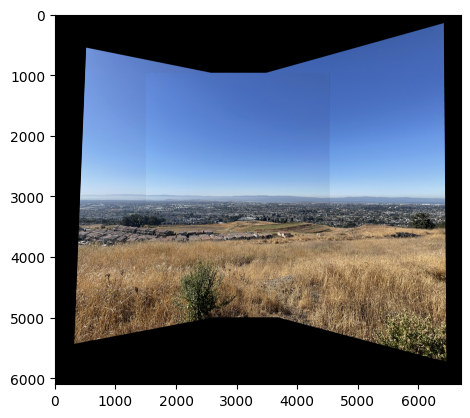

In [10]:
images_garin, masks_garin = compute_mosaic('garin', l=1, c=2, r=3, size_x=6700, size_y=6100, offset_extra_x=0)

(4032, 3024, 3)


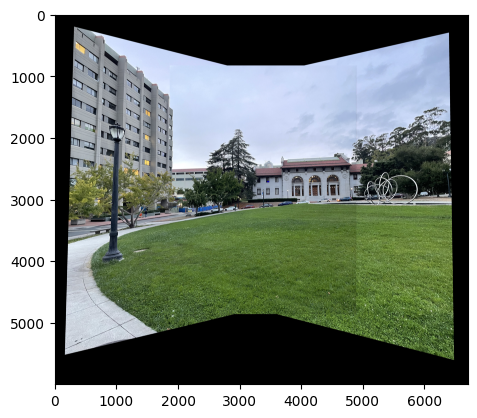

In [11]:
images_evans, masks_evans = compute_mosaic('evans', l=1, c=3, r=5, size_x=6700, size_y=6000, offset_extra_x=360, offset_extra_y=150)

(4032, 3024, 3)


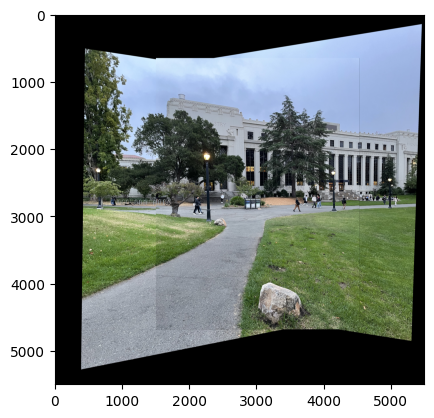

In [12]:
images_vlsb, masks_vlsb = compute_mosaic('vlsb')

In [13]:
def reshape(img, img_to_match):
    new_img = np.zeros_like(img_to_match)
    new_img[:img.shape[0], :img.shape[1], :] = img
    return new_img

In [14]:
dx = np.array([[1, -1]])
dy = np.array([[1], [-1]])
def convolve(filter, img):
    # res = scipy.signal.convolve(img, filter, mode='same')
    # res = scipy.signal.fftconvolve(img, filter, mode='same')
    res = scipy.signal.convolve2d(img, filter, mode='same', boundary='symm')
    # res = np.clip(res, a_min=0, a_max=1)
    return res

def create_gaussian_2d(sigma=3, ksize=19):
    gaussian_1d = cv2.getGaussianKernel(ksize, sigma)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    return gaussian_2d


def create_unit_impulse(filter_shape):
    unit_impulse = np.zeros((filter_shape))
    unit_impulse[unit_impulse.shape[0]//2, unit_impulse.shape[1]//2,] = 1
    return unit_impulse

def create_sharpening_filter(alpha, sigma=3, ksize=18):
    gaussian = create_gaussian_2d(sigma, ksize)
    unit_impulse = create_unit_impulse(gaussian.shape)
    return (1+alpha) * unit_impulse - alpha * gaussian

def convolve_color(filter, img, color=True):
    res = np.zeros_like(img)
    if color:
        res[:,:,0] = convolve(filter, img[:,:,0])
        res[:,:,1] = convolve(filter, img[:,:,1])
        res[:,:,2] = convolve(filter, img[:,:,2])
    else:
        res = convolve(filter, img)
    return res

def opt_ksize(sigma):
    return 6*sigma+1

rgb_2_gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
def add_images(img1, img2):
    c1, c2 =  img1.shape[2] if len(img1.shape) > 2 else 0, img2.shape[2] if len(img2.shape) > 2 else 0
    combined = np.zeros_like(img1) if c1 > c2 else np.zeros_like(img2)
    if c1 > c2:
        for c in range(c1):
            combined[:,:,c] = img1[:,:,c] + img2
    elif c2 > c1:
        for c in range(c2):
            combined[:,:,c] = img2[:,:,c] + img1
    else:
        if c1 > 0:
            for c in range(c1):
                combined[:,:,c] = img2[:,:,c] + img1[:,:,c]
        else:
            combined = img2 + img1
    return combined

In [15]:
import skimage

def rescale_single(a):
    return np.interp(a, (a.min(), a.max()), (0, 1))

def rescale_all_channels(a):
    res = np.zeros_like(a)
    for c in range(a.shape[-1]):
        res[:,:,c] = rescale_single(a[:,:,c])
    return res
    
def create_gaussian_stack(img, levels, sigma=10):
    stack = np.zeros((levels, img.shape[0], img.shape[1], img.shape[2]))
    gaussian_2d = create_gaussian_2d(sigma, opt_ksize(sigma))
    
    stack[0] = img
    prev = stack[0]
    for i in range(1,levels):
        stack[i] = convolve_color(gaussian_2d, prev)
        prev = stack[i]
    return stack

def create_laplacian_stack(gaussian_stack):
    levels = gaussian_stack.shape[0] - 1
    laplacian_stack = np.zeros((levels, gaussian_stack.shape[1], gaussian_stack.shape[2], gaussian_stack.shape[3]))
    
    for i in range(levels):
        laplacian_stack[i] = gaussian_stack[i] - gaussian_stack[i+1]
    return laplacian_stack

def create_stacks(img, levels, sigma=10):
    gaussian_stack = create_gaussian_stack(img, levels+1, sigma)
    laplacian_stack = create_laplacian_stack(gaussian_stack)
    return laplacian_stack, gaussian_stack

def plot_stack(stack, save=False, vertical=False, fname='', show=True):
    levels = stack.shape[0]
    if vertical:
        fig, axes = plt.subplots(levels, 1, figsize=(20, 10))
    else:
        fig, axes = plt.subplots(1, levels, figsize=(10, 20))

    for i, ax in enumerate(axes.flat):
        ax.imshow(rescale_single(stack[i]))  
        ax.axis('off') 
    plt.tight_layout()

    if save:
        plt.savefig('part2_out_dir/part2_3/' + fname + '.jpg',bbox_inches='tight')
    
    if show:
        plt.show()
    
def sum_two_stack(stack1, stack2):
    left = np.sum(stack1, axis=0)
    right = np.sum(stack2, axis=0)
    left_extra_dim = left[np.newaxis, ...]
    right_extra_dim = right[np.newaxis, ...]

    stack1 = np.concatenate((stack1, left_extra_dim))
    stack2 = np.concatenate((stack2, right_extra_dim))

    combined = stack1 + stack2
    return left+right, stack1, stack2, combined

def create_masked_stack(img_stack, mask_stack, invert=False):
    masked_img_stack = np.zeros_like(img_stack)
    if invert:
        mask_stack = 1 - mask_stack
    levels = img_stack.shape[0]
    for i in range(levels):
        masked_img_stack[i] = img_stack[i] * mask_stack[i]
    return masked_img_stack

# Applies the mask onto img1, the inverse onto img2, creates a Laplacian stack, and then returns the collapsed image
def multires_blend(img1, img2, mask, mask_2=None, img_sigma=4, mask_sigma=20, levels=2, save=False, fnames=[], show=False):
    new_mask = mask
    if mask.shape != img1.shape:
        mask = make_mask_3_channel(mask)
    if np.any(mask_2) == None:
        mask_2 = 1-mask
    print(new_mask.shape)
    img1_laplacian_stack, img1_gaussian_stack = create_stacks(img1, levels, img_sigma)
    img2_laplacian_stack, img2_gaussian_stack = create_stacks(img2, levels, img_sigma)

    img1_laplacian_stack[levels-1] = img1_gaussian_stack[levels]
    img2_laplacian_stack[levels-1] = img2_gaussian_stack[levels]
    
    mask_stack = create_gaussian_stack(mask, levels, sigma=mask_sigma)
    mask_2_stack = create_gaussian_stack(mask_2, levels, sigma=mask_sigma)

    masked_stack1 = create_masked_stack(img1_laplacian_stack, mask_stack, invert=False)
    masked_stack2 = create_masked_stack(img2_laplacian_stack, mask_2_stack, invert=False)
    if show:
        plot_stack(mask_stack)
    # plot_stack(mask_2_stack)
    final_img, left, right, combined = sum_two_stack(masked_stack1, masked_stack2)
    
    if show:
        plot_stack(left)
        plot_stack(combined)
        plot_stack(right)
    if save:
        save_img(fnames[1], final_img, out_dir='part2_out_dir/part2_4/')
    return final_img, left, combined, right, img1_laplacian_stack, img2_laplacian_stack, img1_gaussian_stack, img2_gaussian_stack

def create_vertical_mask(img, y):
    left_ones = np.zeros_like(img)
    left_ones[:, :y] = 1
    return left_ones

In [16]:
def combine_with_mask(img1, img2, mask):
    return img1*mask + img2*(1-mask)

# Compute mutually exclusive binary mask using distance transform
def get_dist_mask(mask_1,mask_2):
    dist_1 = scipy.ndimage.distance_transform_edt(mask_1).astype(float)
    dist_1 = dist_1/np.max(dist_1)
    dist_2 = scipy.ndimage.distance_transform_edt(mask_2).astype(float)
    dist_2 = dist_2/np.max(dist_2)
    dist_1_2 = (dist_1 > dist_2).astype(int).astype(float)
    return dist_1_2

# Blend using just the binarized distance transforms
def dist_blend(images, masks):
    dist_mask_2_1 = get_dist_mask(masks[1], masks[2])
    combined_1_2 = combine_with_mask(images[1], images[2], dist_mask_2_1)
    
    dist_mask_12_0 = get_dist_mask(or_masks(masks[1:]), masks[0])
    combined_full = combine_with_mask(combined_1_2, images[0], dist_mask_12_0)
    return combined_full

# Blend using distance transform and laplacian pyramids
def dist_blend_laplacian(images, masks,levels=2, img_sigma=3, mask_sigma=5,show=False):
    # Combine center and right
    img1 = images[1]
    img2 = images[2]
    dist_mask_2_1 = get_dist_mask(masks[1], masks[2])
    white_space = xor_masks(masks[1:])
    mask_1 = or_masks([dist_mask_2_1,white_space])
    mask_2 = or_masks([1-dist_mask_2_1,white_space])

    res = multires_blend(img1, img2, mask_1,mask_2,
                        img_sigma=img_sigma, mask_sigma=mask_sigma, levels=levels,
                        save=False,show=show)
    combined_1_2 = res[0]
    
    # # Combine (center+right) and left
    img1 = combined_1_2
    img2 = images[0]

    combined_1_2_mask = or_masks(masks[1:])
    dist_mask_1_0 = get_dist_mask(combined_1_2_mask, masks[0])
    white_space = xor_masks([combined_1_2_mask, masks[0]])

    mask_1 = or_masks([dist_mask_1_0,white_space])
    mask_2 = or_masks([1-dist_mask_1_0,white_space])

    res = multires_blend(img1, img2, mask_1,mask_2,
                        img_sigma=img_sigma, mask_sigma=mask_sigma, levels=levels,
                        save=False, show=show)
    all_masks = xor_masks([masks[0], combined_1_2_mask])
    return res[0] + all_masks
    # return combined_1_2

In [18]:
# scale_factor = 1/(2**3)
# images_vlsb_ds_8 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_vlsb]
# masks_vlsb_ds_8 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_vlsb]

In [17]:
scale_factor = 1/(2**2)
images_garin_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_garin]
masks_garin_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_garin]

In [18]:
scale_factor = 1/(2**2)
images_vlsb_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_vlsb]
masks_vlsb_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_vlsb]

In [19]:
scale_factor = 1/(2**2)
images_evans_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_evans]
masks_evans_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_evans]

(1500, 1675, 3)


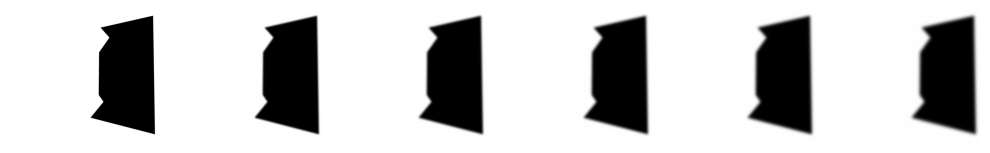

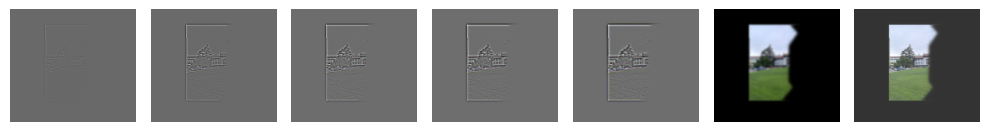

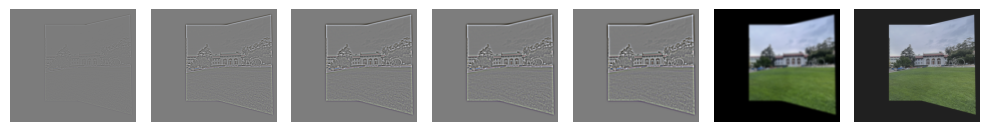

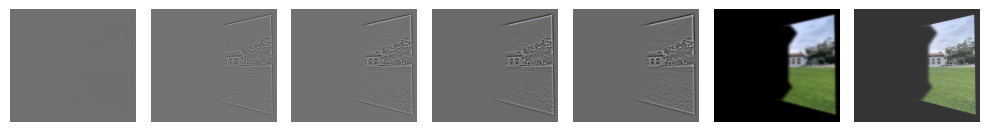

(1500, 1675, 3)


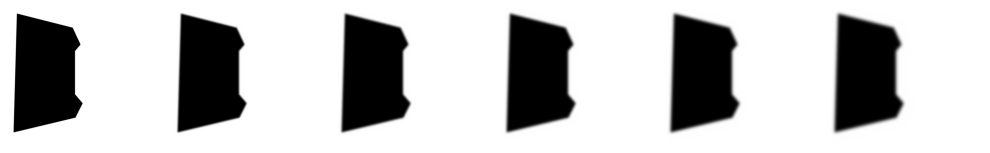

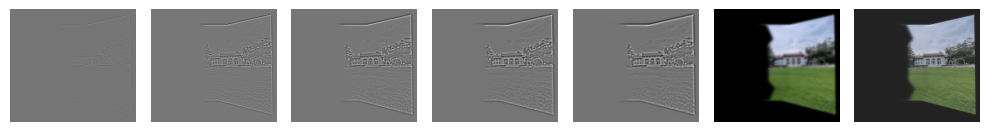

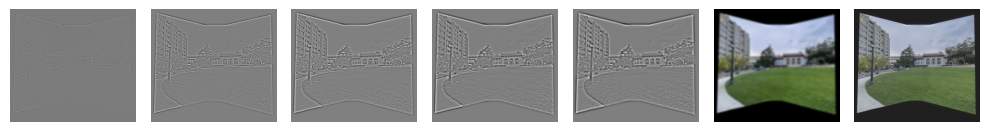

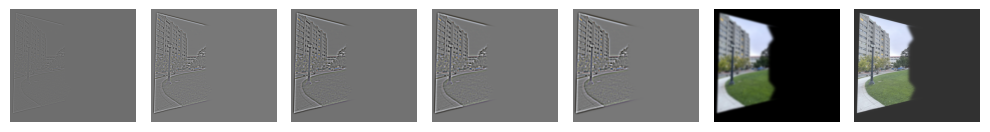

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


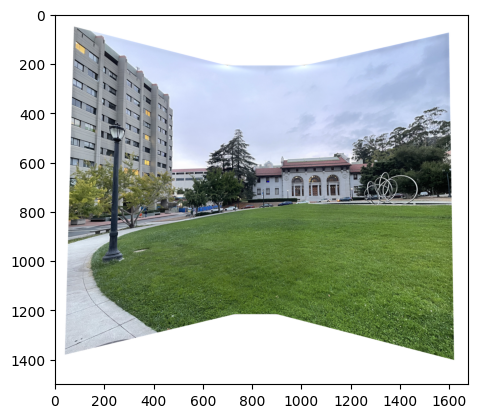

In [20]:
evans_ds_4 = dist_blend_laplacian(images_evans_ds_4, masks_evans_ds_4, levels=6,img_sigma=4, mask_sigma=8, show=True)
plt.imshow(evans_ds_4)
evans_ds_4_xor = evans_ds_4 - xor_masks(masks_evans_ds_4)
save_img('evans_ds_4_6_8', evans_ds_4)
save_img('evans_ds_4_6_8_xor', evans_ds_4_xor)

(1525, 1675, 3)


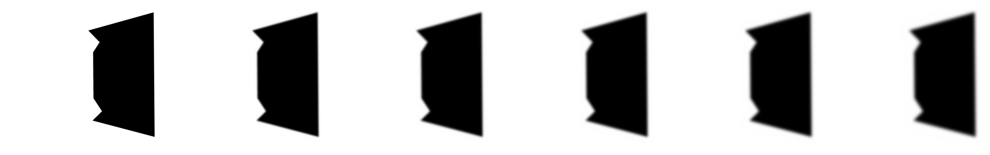

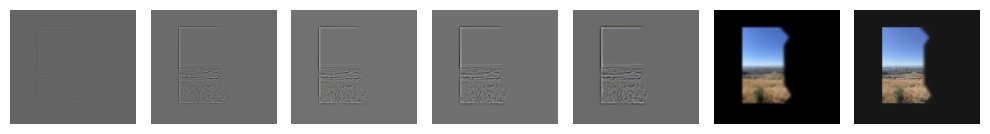

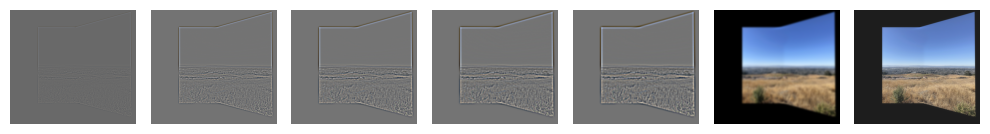

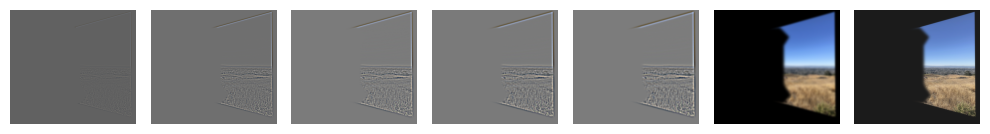

(1525, 1675, 3)


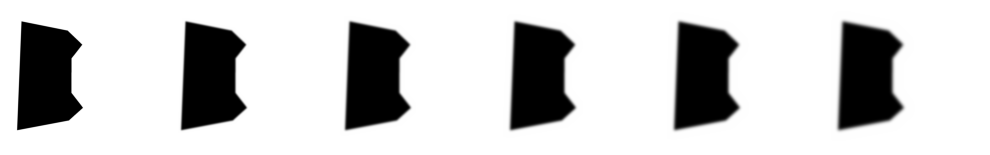

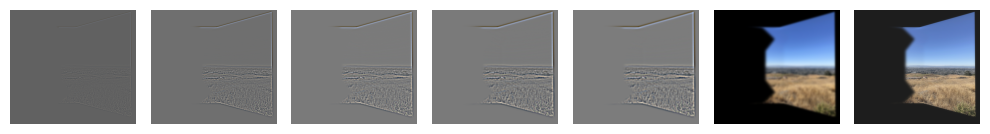

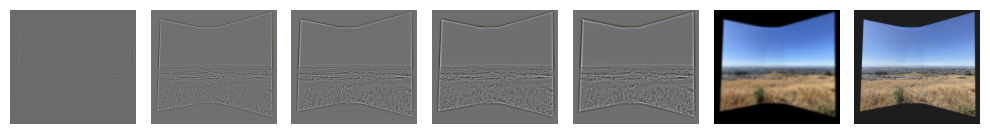

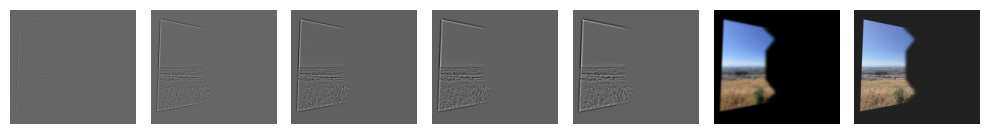

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


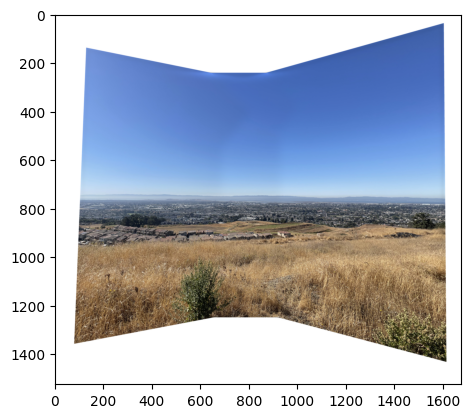

In [21]:
garin_ds_4 = dist_blend_laplacian(images_garin_ds_4, masks_garin_ds_4, levels=6,img_sigma=4, mask_sigma=8, show=True)
plt.imshow(garin_ds_4)
garin_ds_4_xor = garin_ds_4 - xor_masks(masks_garin_ds_4)
save_img('garin_ds_4_6_8', garin_ds_4)
save_img('garin_ds_4_6_8_xor', garin_ds_4_xor)

(1525, 1675, 3)


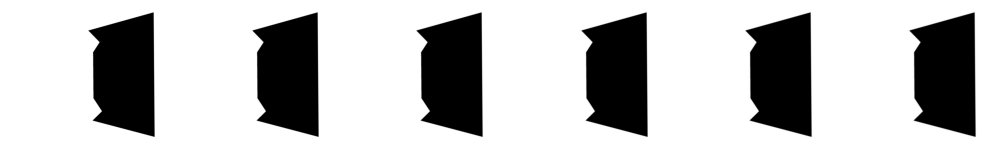

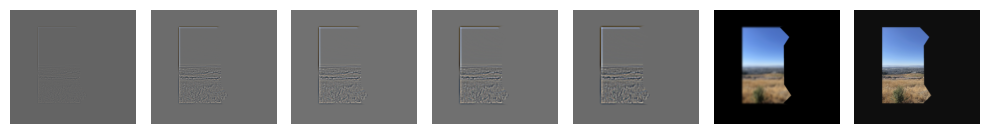

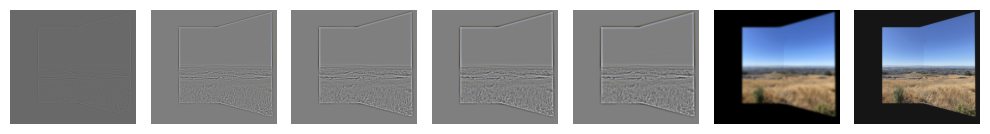

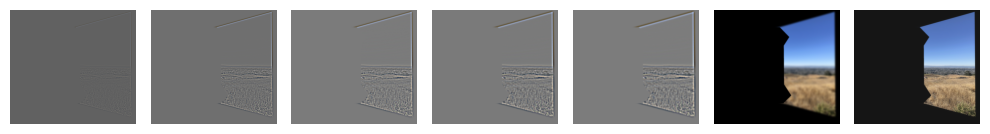

(1525, 1675, 3)


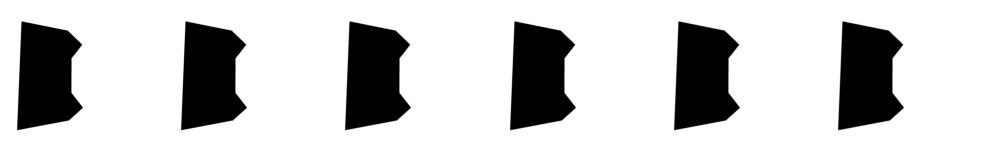

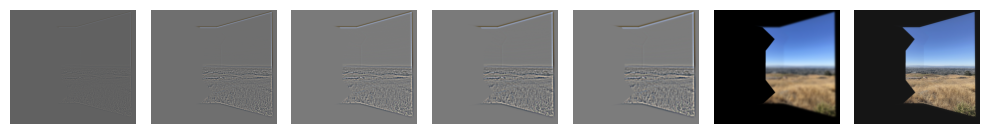

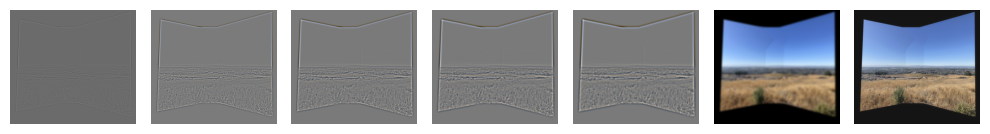

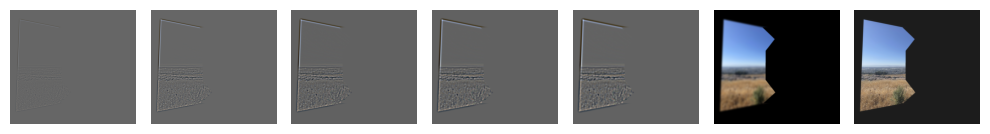

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


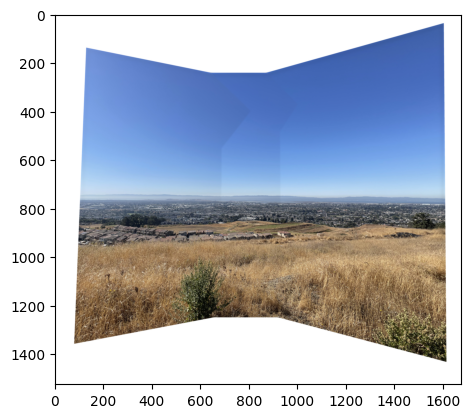

In [24]:
garin_ds_4 = dist_blend_laplacian(images_garin_ds_4, masks_garin_ds_4, levels=6,img_sigma=4, mask_sigma=1, show=True)
plt.imshow(garin_ds_4)
garin_ds_4_xor = garin_ds_4 - xor_masks(masks_garin_ds_4)
# save_img('garin_ds_4_6_12', garin_ds_4)
# save_img('garin_ds_4_6_12_xor', garin_ds_4_xor)

In [ ]:
images_garin_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_garin]


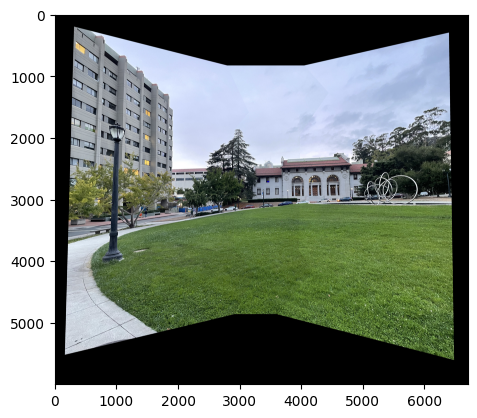

In [277]:
combined = dist_blend(images_evans, masks_evans)
plt.imshow(combined)
save_img('evans_dist', combined)

In [22]:
save_img('ds_garin', images_garin_ds_4[1])